In [1]:
import numpy as np
import scipy as sp
import math

import scipy.stats as stats
from matplotlib import pyplot as plt

## Example of Connection between FFT and Pearson's correlation in 1D

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


Rho coefficient computed on origonal data: -0.7025490108315031 1.6413983198309815e-297


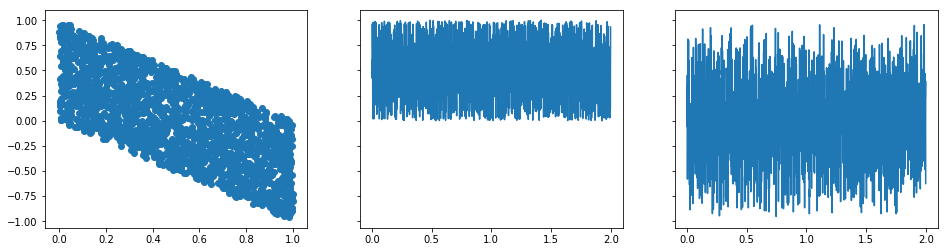

In [233]:
# Generate data
start_time = 0.0;
end_time = 2.0;
Fs = 1000 # samples / second
# delta_t = 1 / Fs # seconds / sample
time, delta_t = np.linspace(start_time, end_time, num=(end_time - start_time) * Fs, endpoint=False, retstep=True)


RANDOM = True
if RANDOM: 
    # Generate random data 
    np.random.seed(0)
    x = np.random.rand(time.shape[0], 2)

    # Correlate data
    x[:, 1] = -x[:, 0] + x[:, 1]
else:
    A = 2.5 # signal amplitude 
    freq = 7.8 # Hz
    noise = 0.1 # noise amplitude
    phi_angle = 63.0 # in degrees
    x1 = A*np.cos(2.0*np.pi*freq*time + phi_angle / 180.0 * np.pi) # For DFT, cosine has 0 phase
    
    # Generate a highly correlated signal
    np.random.seed(0)
    x2 = x1 + noise*np.random.rand(time.shape[0],)
    
    # Stack into a single data fector
    x = np.vstack((x1, x2)).T

# Plot individual signals and joint 
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(16, 4))
ax[0].scatter(x[:, 0], x[:, 1])
ax[1].plot(time, x[:, 0])
ax[2].plot(time, x[:, 1])

# Compute the Pearsons' rho correlation coefficient between the two signals
rho, pvalue = stats.pearsonr(x[:, 0], x[:, 1])
print("Rho coefficient computed on origonal data:", rho, pvalue)

### Data Normalization
There are several differnt ways to compute the Pearson's $\rho$ correlation coefficient. 
By definition, for two random variables $\mathbf{x}$ and $\mathbf{y}$:
$$ \rho_{\mathbf{x}, \mathbf{y}} = \frac{\text{cov}(\mathbf{x}, \mathbf{y})}{\sigma_{\mathbf{x}} \sigma_{\mathbf{y}}}, $$
where $\sigma_{\mathbf{x}}$, $\sigma_{\mathbf{y}}$ are the standard deviations and:
$$ \text{cov}(\mathbf{x}, \mathbf{y}) = \mathbb{E}[(\mathbf{x} - \mu_{\mathbf{x}})(\mathbf{y} - \mu_{\mathbf{y}})].$$

When computing Pearson's $\rho$ on a sample of data $\{(x_1, y_1), \dots, (x_y, y_n)\}$:
$$ \hat{\rho}_{\mathbf{x}, \mathbf{y}} = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^n (x_i - \bar{x})^2}\sqrt{\sum_{i=0}^n (y_i - \bar{y})^2}}. $$

Alternatively, we can first normalize the data (compute the standard score for each variable):
\begin{align}
\hat{\mathbf{x}} = \frac{\mathbf{x} - \mu_{\mathbf{x}}}{\sigma_{\mathbf{x}}} \\
\hat{\mathbf{y}} = \frac{\mathbf{y} - \mu_{\mathbf{y}}}{\sigma_{\mathbf{y}}}. \\
\end{align}

Then the Pearson's $\rho$ correlation can be computed as the mean of the products of the standard scores:
$$\hat{\rho}_{\mathbf{x}, \mathbf{y}} = \frac{1}{n-1} \sum_{i=1}^n \hat{x_i} \hat{y_i} $$

In [234]:
# Normalize data so that mean = 0 and std = 1
x_hat = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
print("Mean and std normalized to:", np.mean(x_hat), np.std(x_hat))

# Rho and p_value form Pearson's test should be unchanged
rho_hat, pvalue_hat = stats.pearsonr(x_hat[:, 0], x_hat[:, 1])
print("Rho coefficient computed by libaray:", rho_hat, pvalue_hat)

Mean and std normalized to: 3.47277762102749e-16 0.9999999999999996
Rho coefficient computed by libaray: -0.7025490108315031 1.6413983198309815e-297


In [235]:
# Alternatively, compute the Pearson's coefficient using the Euclidean distance
from scipy.spatial import distance
# Compute np.sqrt(np.sum(((data_hat[:, 0] - data_hat[:, 1])**2)))
dist_euc = distance.euclidean(x_hat[:, 0], x_hat[:, 1])
rho_euc = 1 - (dist_euc**2 / (2 * x_hat.shape[0]))
print("Rho coefficient computed from Euclidean distance", rho_euc)

Rho coefficient computed from Euclidean distance -0.7025490108315016


Using 2048 samples for the FFT out of 2000
Removing coefficeints with magnitude lower then: [0.00055515 0.00065125]
Peak frequency at [98.6328125 98.6328125] with phase [  10.70457314 -171.38355406]
Rho coefficient computed from frequency domain -0.662225791830463


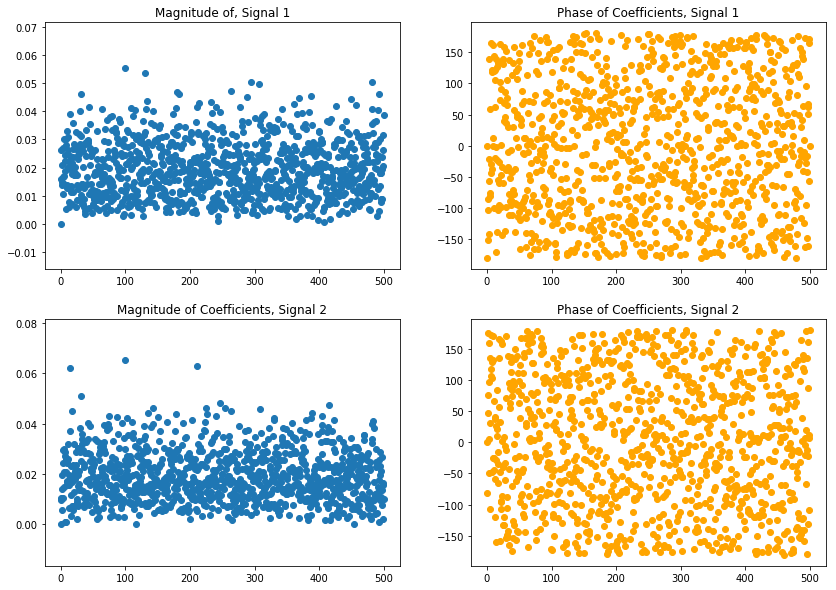

In [245]:
# Transform data using the FFT 
N = x_hat.shape[0]

# The FFT requies that data length be a power of 2, so compute the next power of 2
N_fft = (2**int(np.ceil(np.log2(N))))
# N_fft = N
print("Using", N_fft, "samples for the FFT out of", N)

# Perform the FFT
# X_hat = 1 / N_fft * np.fft.fftshift(np.fft.fft(x_hat, n=N_fft, axis=0, norm=None))
# X_hat = np.fft.fft(x_hat, n=N_fft, axis=0, norm='ortho')
X_hat = 1.0 / N_fft * np.fft.fft(x_hat, n=N_fft, axis=0, norm=None)

# Remove low magnitude components
FILTER = True
if FILTER:
    eps = np.max(np.abs(X_hat), axis=0) / 100
    print("Removing coefficeints with magnitude lower then:", eps)
    X_hat[np.abs(X_hat) < eps] = 0.0

bins = np.arange(N_fft) * Fs / N_fft
nyquist_num = N_fft // 2 + 1
X_hat = X_hat[0:nyquist_num, :]
bins = bins[0:nyquist_num]

# Compute the magnitude and phase of the complex signal
mag = np.abs(X_hat)
phase = np.arctan2(X_hat.imag, X_hat.real) / np.pi * 180.0

# Plot the complex magnitude and phase
f, ax = plt.subplots(2, 2, figsize=(14, 10))
ax[0,0].scatter(bins, mag[:, 0])
ax[0,0].set_title('Magnitude of, Signal 1')
ax[0,1].scatter(bins, phase[:, 0], c='orange')
ax[0,1].set_title('Phase of Coefficients, Signal 1')
ax[1,0].scatter(bins, mag[:, 1])
ax[1,0].set_title('Magnitude of Coefficients, Signal 2')
ax[1,1].scatter(bins, phase[:, 1], c='orange')
ax[1,1].set_title('Phase of Coefficients, Signal 2')

# Find the maximum magnitude frequency
max_index = np.argmax(mag, axis=0)
print("Peak frequency at", bins[max_index], "with phase", phase[max_index, [0, 1]])

# Compute the appropriate normalization for the FFT for correlation
X_hat = np.sqrt(N_fft) * X_hat
dist_freq = distance.euclidean(X_hat[:, 0], X_hat[:, 1])
rho_freq = 1 - (dist_freq**2 / (2 * X_hat.shape[0]))
print("Rho coefficient computed from frequency domain", rho_freq)

Correlation Approximation Error: 0.042818672089415886


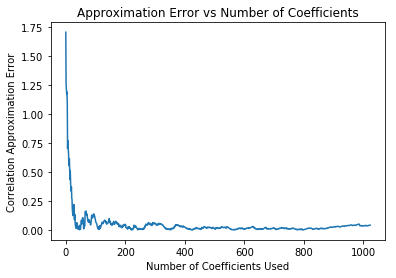

In [246]:
# Plot correlation error versus number of Fourier coefficients used
rho_approx = []
for i in range(1, nyquist_num):
    X_hat_approx = X_hat[0:i, :]
    dist_freq_approx = distance.euclidean(X_hat_approx[:, 0], X_hat_approx[:, 1])
    rho_freq_approx = 1 - (dist_freq_approx**2 / (2 * X_hat_approx.shape[0]))
    rho_approx.append(np.abs(rho_freq_approx - rho_hat))
    
plt.plot(rho_approx)
plt.title('Approximation Error vs Number of Coefficients')
plt.xlabel('Number of Coefficients Used')
plt.ylabel('Correlation Approximation Error')
print("Correlation Approximation Error:", np.mean(rho_approx))

Correlation Approximation Error: 0.5003232178315148


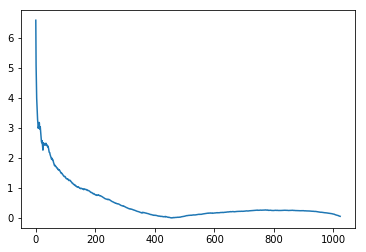

In [244]:
# Plot correlation error versus number of Fourier coefficients used after sorting data
index = np.argsort(X_hat[:, 0])
X_hat_sort = X_hat[index, :]

rho_approx = []
for i in range(1, nyquist_num):
    X_hat_approx = X_hat_sort[0:i, :]
    dist_freq_approx = distance.euclidean(X_hat_approx[:, 0], X_hat_approx[:, 1])
    rho_freq_approx = 1 - (dist_freq_approx**2 / (2 * X_hat_approx.shape[0]))
    rho_approx.append(np.abs(rho_freq_approx - rho_hat))
    
plt.plot(rho_approx)
print("Correlation Approximation Error:", np.mean(rho_approx))

In [228]:
import cmath
import math

# Transform data using the FFT 
N = x_hat.shape[0]

# The FFT requies that data length be a power of 2, so compute the next power of 2
N_fft = (2**int(np.floor(np.log2(N))))
print("Using", N_fft, "samples for the FFT out of", N)

# Perform the FFT
# X_hat = 1 / N_fft * np.fft.fftshift(np.fft.fft(x_hat, n=N_fft, axis=0, norm=None))
X_hat = 1 / N_fft * np.fft.fft(x_hat, n=N_fft, axis=0, None)

# Remove low magnitude components
FILTER = True
if FILTER:
    eps = np.max(np.abs(X_hat), axis=0) / 100
    print("Removing coefficeints with magnitude lower then:", eps)
    X_hat[np.abs(X_hat) < eps] = 0.0

bins = np.arange(N_fft) * Fs / N_fft
# bins = np.arange(-N_fft // 2, N_fft//2, 1) * Fs / N_fft
nyquist_num = N_fft // 2 + 1
X_hat = X_hat[0:nyquist_num, :]
bins = bins[0:nyquist_num]

# Compute the magnitude and phase of the complex signal
mag = np.abs(X_hat)
phase = np.arctan2(X_hat.imag, X_hat.real) / np.pi * 180.0

f, ax = plt.subplots(2, 2, figsize=(14, 10))
ax[0,0].scatter(bins, mag[:, 0])
ax[0,0].set_title('Magnitude of, Signal 1')
ax[0,1].scatter(bins, phase[:, 0], c='orange')
ax[0,1].set_title('Phase of Coefficients, Signal 1')
ax[1,0].scatter(bins, mag[:, 1])
ax[1,0].set_title('Magnitude of Coefficients, Signal 2')
ax[1,1].scatter(bins, phase[:, 1], c='orange')
ax[1,1].set_title('Phase of Coefficients, Signal 2')

max_index = np.argmax(mag, axis=0)
print("Peak frequency at", bins[max_index], "with phase", phase[max_index, [0, 1]])

# Compute the appropriate normalization for the FFT for correlation
# X_hat = 1/(N_fft) * X_hat
dist_freq = distance.euclidean(X_hat[:, 0], X_hat[:, 1])
rho_freq = 1 - (dist_freq**2 / (2 * X_hat.shape[0]))
print("Rho coefficient computed from frequency domain", rho_freq)

SyntaxError: positional argument follows keyword argument (<ipython-input-228-09969f61c489>, line 13)